# Data Analysis of bolt demand data

In [ ]:
# imports
import pandas as pd
import geopandas as gpd

import h3
import folium

from shapely.geometry import Polygon
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
import branca

In [10]:
# variables
INPUT_FILE_PATH = "../processed_data/bolt_demand_h3.pickle"

In [11]:
df = pd.read_pickle(INPUT_FILE_PATH)
df = gpd.GeoDataFrame(df)
df.reset_index(inplace=True)
df.head()

,timestamp,bike_id,current_range_meters,current_fuel_percent,event_type,geometry,grid_index,community_index
0,2025-02-11 14:42:07,BLT:Vehicle:740666c5-38af-4cd9-8ea8-d7a4b623294b,23800.0,0.44,pickup,POINT (9.23838 48.82612),881faa718bfffff,861faa71fffffff
1,2025-02-11 14:42:07,BLT:Vehicle:c736bf7f-9e1b-40df-af6c-afb04271040e,22400.0,0.42,pickup,POINT (9.07409 48.74804),881faa7b13fffff,861faa787ffffff
2,2025-02-11 14:42:07,BLT:Vehicle:f7b43738-0836-4443-9d7a-723976f84870,14000.0,0.30,pickup,POINT (9.18369 48.80967),881faa7133fffff,861faa717ffffff
3,2025-02-11 14:42:07,BLT:Vehicle:50f1520d-feea-47e2-afb3-56ec8064d9b5,46900.0,0.77,pickup,POINT (9.16575 48.74136),881faa78cdfffff,861faa78fffffff
4,2025-02-11 14:42:07,BLT:Vehicle:e1c6c470-1032-4ea6-94b6-e69de8492a97,35000.0,0.60,pickup,POINT (9.18678 48.78089),881faa7a8bfffff,861faa7afffffff


## Temporal time bining

In [12]:
time_bins = [0, 5, 9, 13, 20]
time_labels = ["morning", "midday", "afternoon", "evening"]
df["time_bin"] = pd.cut(
    df["timestamp"].dt.hour, bins=time_bins, labels=time_labels, right=False
)

In [ ]:
pickup_demand = df[df["event_type"] == "pickup"].copy()
dropoff_demand = df[df["event_type"] == "dropoff"].copy()

pickup_demand.drop(columns=["event_type"], inplace=True)
dropoff_demand.drop(columns=["event_type"], inplace=True)

len(pickup_demand), len(dropoff_demand)

(188497, 188519)

In [14]:
pickup_demand["grid_index"].nunique()

233

## Heatmap plot

In [ ]:
def display_as_heatmap(temp_df):
    grid_counts = temp_df["grid_index"].value_counts().reset_index()
    grid_counts.columns = ["grid_index", "count"]

    grid_polygons = []
    for idx in grid_counts["grid_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in grid_polygons],
        crs="EPSG:4326",
    )

    bounds = grid_gdf.total_bounds
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    m_pickup = folium.Map(
        location=[mean_lat_pickup, mean_lon_pickup],
        no_touch=True,
        dragging=False,
        zoom_control=False,
    )

    def get_color(count, max_count):
        norm = Normalize(vmin=0, vmax=max_count**0.9)
        colormap = cm.get_cmap("viridis")
        rgba_color = colormap(norm(count))
        return to_hex(rgba_color)

    max_count = grid_gdf["count"].max()

    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row["count"]: {
                "fillColor": get_color(count, max_count),
                "color": "transparent",
                "weight": 1,
                "fillOpacity": 0.7,
            },
            tooltip=f"Count: {row['count']}, Grid Index: {row['grid_index']}",
        ).add_to(m_pickup)

    community_counts = temp_df["community_index"].value_counts().reset_index()
    community_counts.columns = ["community_index", "count"]
    community_counts["cell_count"] = temp_df.groupby("community_index")[
        "grid_index"
    ].transform("nunique")
    community_counts = community_counts[community_counts["count"] > 50]

    community_polygons = []
    for idx in community_counts["community_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        community_polygons.append(polygon_geojson)

    community_gdf = gpd.GeoDataFrame(
        community_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in community_polygons],
        crs="EPSG:4326",
    )

    for idx, row in community_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x: {"color": "black", "weight": 1, "fillOpacity": 0},
            tooltip=f"Community Index : {row['community_index']}, Count: {row['count']}, Cell Count: {row['cell_count']}",
        ).add_to(m_pickup)

    m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    print(f"Map bounds: {bounds}")

    return m_pickup

In [16]:
display_as_heatmap(pickup_demand)

/tmp/ipykernel_1273994/2746467224.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


Map bounds: [ 9.05813634 48.6958345   9.28504168 48.8581477 ]


/tmp/ipykernel_1273994/2746467224.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


In [17]:
display_as_heatmap(dropoff_demand)

/tmp/ipykernel_1273994/2746467224.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


Map bounds: [ 9.05813634 48.6958345   9.28504168 48.8581477 ]


/tmp/ipykernel_1273994/2746467224.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


## Hourly Line Plots (Weekday vs. Weekend)

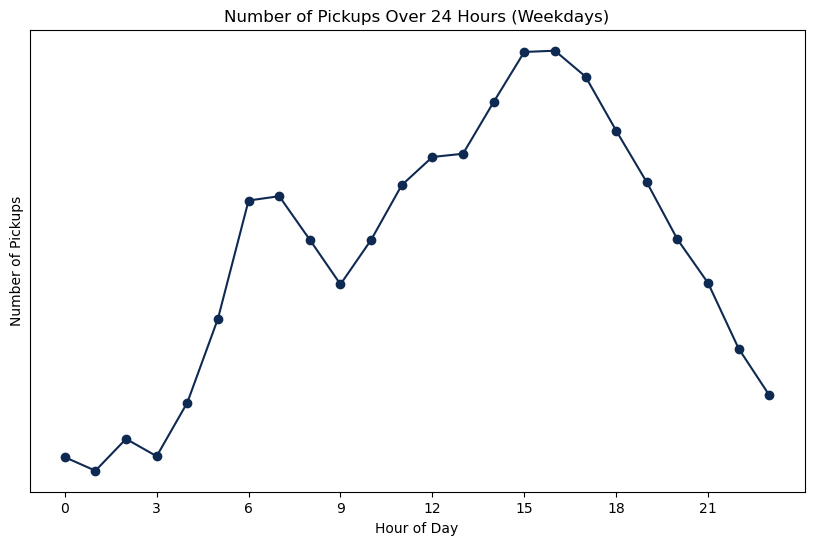

In [ ]:
pickup_hourly_weekday = (
    pickup_demand[pickup_demand["timestamp"].dt.dayofweek < 5]["timestamp"]
    .dt.hour.value_counts()
    .sort_index()
)

plt.figure(figsize=(10, 6))
plt.plot(
    pickup_hourly_weekday.index,
    pickup_hourly_weekday.values,
    marker="o",
    linestyle="-",
    color="#0F2A52",
)
plt.title("Number of Pickups Over 24 Hours (Weekdays)")
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.show()

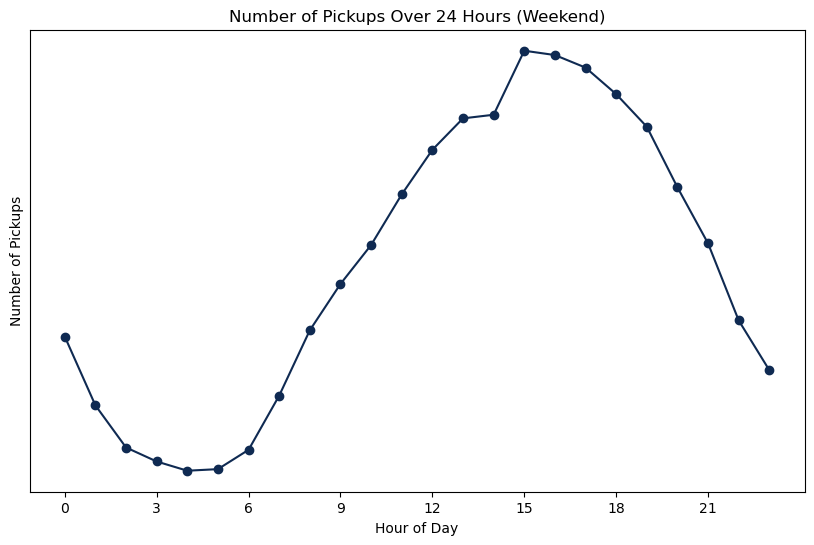

In [ ]:
pickup_hourly_weekend = (
    pickup_demand[pickup_demand["timestamp"].dt.dayofweek >= 5]["timestamp"]
    .dt.hour.value_counts()
    .sort_index()
)

plt.figure(figsize=(10, 6))
plt.plot(
    pickup_hourly_weekend.index,
    pickup_hourly_weekend.values,
    marker="o",
    linestyle="-",
    color="#0F2A52",
)
plt.title("Number of Pickups Over 24 Hours (Weekend)")
plt.xticks(range(0, 24, 3))
plt.yticks([])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.show()

## Imbalance Hourly Plot

In [ ]:
pickup_hourly = (
    pickup_demand.groupby([pickup_demand["timestamp"].dt.hour, "grid_index"])
    .size()
    .reset_index()
)
pickup_hourly.columns = ["hour", "grid_index", "pickup_count"]

dropoff_hourly = (
    dropoff_demand.groupby([dropoff_demand["timestamp"].dt.hour, "grid_index"])
    .size()
    .reset_index()
)
dropoff_hourly.columns = ["hour", "grid_index", "dropoff_count"]

rebalance_data = pd.merge(
    pickup_hourly, dropoff_hourly, on=["hour", "grid_index"], how="outer"
).fillna(0)
rebalance_data["imbalance"] = (
    rebalance_data["pickup_count"] - rebalance_data["dropoff_count"]
)

rebalance_data_aggregated = (
    rebalance_data.groupby("hour").agg({"imbalance": "sum"}).reset_index()
)

rebalance_data.head()

,hour,grid_index,pickup_count,dropoff_count,imbalance
0,0,881faa6301fffff,6.0,2.0,4.0
1,0,881faa6303fffff,19.0,19.0,0.0
2,0,881faa6305fffff,10.0,11.0,-1.0
3,0,881faa6307fffff,13.0,7.0,6.0
4,0,881faa6309fffff,1.0,0.0,1.0


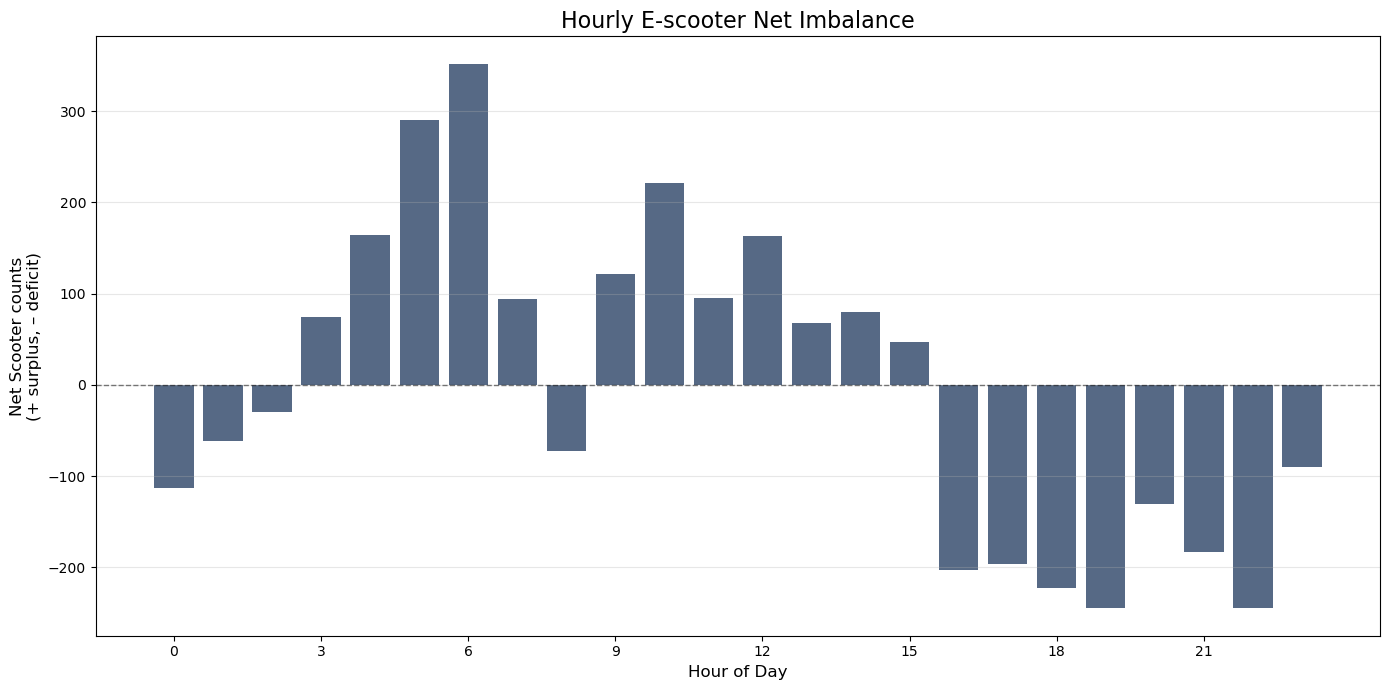

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(
    rebalance_data_aggregated["hour"],
    rebalance_data_aggregated["imbalance"],
    width=0.8,
    label="Net Imbalance (Pickups – Dropoffs)",
    color="#0F2A52",
    alpha=0.7,
)

ax.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.5)

ax.set_xlabel("Hour of Day", fontsize=12)
ax.set_ylabel("Net Scooter counts\n(+ surplus, – deficit)", fontsize=12)
ax.set_xticks(range(0, 24, 3))
ax.grid(axis="y", alpha=0.3)

plt.title("Hourly E-scooter Net Imbalance", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def display_imbalance_as_heatmap(rebalance_data):
    grid_counts = (
        rebalance_data.groupby("grid_index")["imbalance"].agg("sum").reset_index()
    )
    grid_counts.columns = ["grid_index", "imbalance"]

    grid_polygons = []
    for idx in grid_counts["grid_index"]:
        polygon_geojson = h3.cell_to_boundary(idx)
        grid_polygons.append(polygon_geojson)

    grid_gdf = gpd.GeoDataFrame(
        grid_counts,
        geometry=[Polygon([(p[1], p[0]) for p in poly]) for poly in grid_polygons],
        crs="EPSG:4326",
    )

    bounds = grid_gdf.total_bounds
    mean_lat_pickup = (bounds[1] + bounds[3]) / 2
    mean_lon_pickup = (bounds[0] + bounds[2]) / 2

    m_pickup = folium.Map(
        location=[mean_lat_pickup, mean_lon_pickup], tiles="Cartodb Positron"
    )

    def get_color(count, max_abs):
        # red means deficit, blue means surplus
        cmap = branca.colormap.LinearColormap(
            colors=["blue", "white", "red"],
            vmin=-max_abs,
            vmax=+max_abs,
            caption="Net Imbalance (pickups – dropoffs)",
        ).to_step(10)
        rgba = cmap(count)
        return to_hex(rgba)

    max_abs = grid_gdf["imbalance"].abs().max()

    for idx, row in grid_gdf.iterrows():
        folium.GeoJson(
            row.geometry.__geo_interface__,
            style_function=lambda x, count=row["imbalance"]: {
                "fillColor": get_color(count, max_abs),
                "color": "transparent",
                "weight": 1,
                "fillOpacity": 0.7,
            },
            tooltip=f"Imbalance: {row['imbalance']}, Grid Index: {row['grid_index']}",
        ).add_to(m_pickup)

    m_pickup.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

    return m_pickup

## Imbalance Map Plots
Red cells are areas where more pick-up events happen than drop-offs

### Imbalance in the morning peak

In [ ]:
display_imbalance_as_heatmap(
    rebalance_data[(rebalance_data["hour"] >= 3) & (rebalance_data["hour"] < 8)],
)

### Imbalance at evening peak

In [ ]:
display_imbalance_as_heatmap(
    rebalance_data[(rebalance_data["hour"] >= 15) & (rebalance_data["hour"] < 20)],
)